# Conditional Variational AutoEncoder (CVAE) on MNIST data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import tensorflow as tf
from sklearn import model_selection

from keras import layers
from keras import models
from keras import Model
from keras.datasets import mnist
from keras import backend as K
from keras import metrics
from keras import optimizers

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
# The Function used to plot the original image and the predicted image
def Plot_Img(n,k,images,fig_w,fig_h):
    # n is how many digits we will display
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k, k))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixels to 0 and 1 range
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape each image matrix to a long vector
x_train = np.reshape(x_train, (len(x_train), 28*28))  
x_test = np.reshape(x_test, (len(x_test), 28*28))  
print (x_train.shape)
print (x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


In [0]:
batch_size = 100
input_dim = 28*28
layer_dim = 256
h_dim = 20

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(h_dim,),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

def vae_loss(x, decode_z):
    x = K.flatten(x)
    decode_z = K.flatten(decode_z)
    xent_loss = K.sum(K.binary_crossentropy(x, decode_z), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + vae_log_var - K.square(vae_mu) - K.exp(vae_log_var), axis=-1)
    return xent_loss + kl_loss

##Variational Autoencoder

In [5]:
# Construct the Fully-Connected VAE model
vae_Input = layers.Input(batch_shape=(batch_size,input_dim,))
vae_f1 = layers.Dense(layer_dim,activation='relu')(vae_Input)
vae_f2 = layers.Dense(layer_dim,activation='relu')(vae_f1)
vae_mu = layers.Dense(h_dim,activation='relu')(vae_f2)
vae_log_var = layers.Dense(h_dim,activation='relu')(vae_f2)

# Imputed latent values
vae_z = layers.Lambda(sampling, output_shape=(h_dim,))([vae_mu, vae_log_var])

# VAE decoder layers
vae_decoder_f1 = layers.Dense(layer_dim,activation='relu')
vae_decoder_f2 = layers.Dense(layer_dim,activation='relu')
vae_decoder_out = layers.Dense(input_dim,activation='sigmoid')

# VAE model
vae_decoder_1 = vae_decoder_f1(vae_z)
vae_decoder_2 = vae_decoder_f2(vae_decoder_1)
vae_decoded = vae_decoder_out(vae_decoder_2)
vae = Model(vae_Input,vae_decoded)
vae.summary()

# The decoder model
vae_z_input = layers.Input(batch_shape=(batch_size,h_dim,))
x = vae_decoder_f1(vae_z_input)
x = vae_decoder_f2(x)
x = vae_decoder_out(x)
vae_decoder = Model(vae_z_input,x)
vae_decoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (100, 784)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (100, 256)           200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (100, 256)           65792       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (100, 20)            5140        dense_2[0][0]                    
_____________________________________

In [6]:
vae_opt = optimizers.Adam(0.0005,0.5)
vae.compile(optimizer=vae_opt, loss=vae_loss)
vae.fit(x_train,x_train,epochs=50,batch_size=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 6s 96us/step - loss: 19104.5772
Epoch 2/50
60000/60000 [==============================] - 4s 75us/step - loss: 13289.5332
Epoch 3/50
60000/60000 [==============================] - 5s 78us/step - loss: 11782.0708
Epoch 4/50
60000/60000 [==============================] - 5s 75us/step - loss: 10940.8817
Epoch 5/50
60000/60000 [==============================] - 4s 75us/step - loss: 10465.0152
Epoch 6/50
60000/60000 [==============================] - 4s 75us/step - loss: 10109.6907
Epoch 7/50
60000/60000 [==============================] - 4s 75us/step - loss: 9838.0589
Epoch 8/50
60000/60000 [==============================] - 4s 74us/step - loss: 9642.1604
Epoch 9/50
60000/60000 [==============================] - 4s 74us/step - loss: 9485.4864
Epoch 10/50
60000/60000 [==============================] - 5s 77us/step - loss: 9353.3456
Epoch 11/50
60000/60000 [==============================

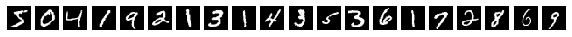

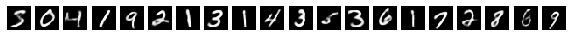

In [7]:
vae_recons = vae.predict(x_train)
Plot_Img(20,28,x_train,10,10)
Plot_Img(20,28,vae_recons,10,10)
plt.show()

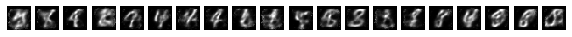

In [32]:
z_sample = np.random.normal(size=(batch_size,h_dim,))
z_sample = tf.convert_to_tensor(z_sample, dtype=tf.float32)
Plot_Img(20,28,vae_decoder.predict(z_sample,steps=1),10,10)

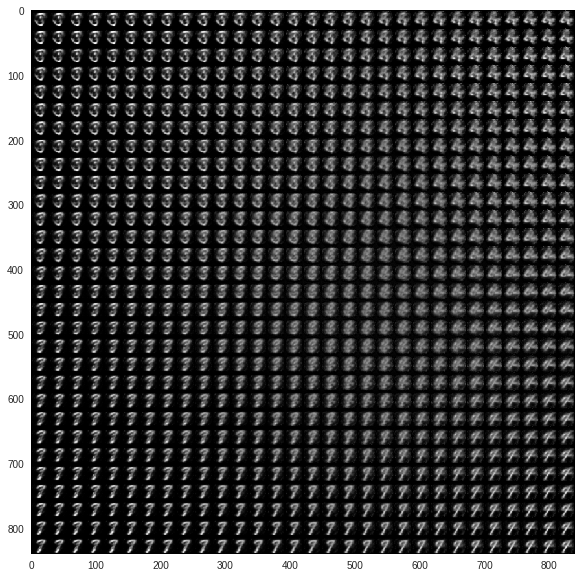

In [31]:
# display a 2D manifold of the digits
n = 30  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)
rest = [1 for i in range(18)]


for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]+rest])
        x_decoded = vae_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size,digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='Greys_r')
plt.grid(b=None)
plt.show()

# Conditional Variational Autoencoder conditioning on Labels

In [33]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
print(y_train.shape)

(60000, 10)


In [0]:
batch_size = 100
input_dim = 28*28
layer_dim = 512
h_dim = 20
cond_dim = y_train.shape[1]

def csampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size,h_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

def cvae_loss(x, decode_z):
    x = K.flatten(x)
    decode_z = K.flatten(decode_z)
    xent_loss = K.sum(K.binary_crossentropy(x, decode_z), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + cvae_log_var - K.square(cvae_mu) - K.exp(cvae_log_var), axis=-1)
    return xent_loss + kl_loss

In [38]:
# Construct the Fully-Connected CVAE model
X = layers.Input(batch_shape=(batch_size,input_dim))
cond = layers.Input(batch_shape=(batch_size,cond_dim))
cvae_Input = layers.concatenate([X,cond], axis=-1)
cvae_f1 = layers.Dense(layer_dim,activation='relu')(cvae_Input)
#cvae_f2 = layers.Dense(layer_dim,activation='relu')(cvae_f1)
cvae_mu = layers.Dense(h_dim,activation='relu')(cvae_f1)
cvae_log_var = layers.Dense(h_dim,activation='relu')(cvae_f1)

# Imputed latent values
cvae_z = layers.Lambda(csampling, output_shape=(h_dim,))([cvae_mu, cvae_log_var])
cvae_z_cond = layers.concatenate([cvae_z,cond], axis=-1)

# CVAE decoder layers
cvae_decoder_f1 = layers.Dense(layer_dim,activation='relu')
#cvae_decoder_f2 = layers.Dense(layer_dim,activation='relu')
cvae_decoder_out = layers.Dense(input_dim,activation='sigmoid')

# CVAE model
cvae_decoder_1 = cvae_decoder_f1(cvae_z_cond)
#cvae_decoder_2 = cvae_decoder_f2(cvae_decoder_1)
cvae_decoded = cvae_decoder_out(cvae_decoder_1)
cvae = Model([X,cond],cvae_decoded)
cvae.summary()

# The decoder model
cvae_z_input1 = layers.Input(batch_shape=(batch_size,h_dim))
cvae_z_input2 = layers.Input(batch_shape=(batch_size,cond_dim))
cx = layers.concatenate([cvae_z_input1,cvae_z_input2], axis=-1)
cx = cvae_decoder_f1(cx)
#cx = cvae_decoder_f2(cx)
cx = cvae_decoder_out(cx)
cvae_decoder = Model([cvae_z_input1,cvae_z_input2],cx)
cvae_decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (100, 784)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (100, 10)            0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (100, 794)           0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (100, 512)           407040      concatenate_4[0][0]              
__________

In [39]:
cvae_opt = optimizers.Adam(0.0005,0.5)
cvae.compile(optimizer=cvae_opt, loss=cvae_loss)
cvae.fit([x_train,y_train],x_train,epochs=20,batch_size=batch_size)

Epoch 1/20
60000/60000 [==============================] - 5s 84us/step - loss: 15103.8078
Epoch 2/20
60000/60000 [==============================] - 5s 77us/step - loss: 10299.1321
Epoch 3/20
60000/60000 [==============================] - 5s 76us/step - loss: 9597.7241
Epoch 4/20
60000/60000 [==============================] - 5s 77us/step - loss: 9250.2894
Epoch 5/20
60000/60000 [==============================] - 5s 78us/step - loss: 9021.7197
Epoch 6/20
60000/60000 [==============================] - 5s 77us/step - loss: 8856.2963
Epoch 7/20
60000/60000 [==============================] - 5s 77us/step - loss: 8737.5622
Epoch 8/20
60000/60000 [==============================] - 5s 78us/step - loss: 8638.1496
Epoch 9/20
60000/60000 [==============================] - 5s 77us/step - loss: 8538.6714
Epoch 10/20
60000/60000 [==============================] - 5s 76us/step - loss: 8447.6868
Epoch 11/20
60000/60000 [==============================] - 4s 75us/step - loss: 8379.1125
Epoch 12/20
60000

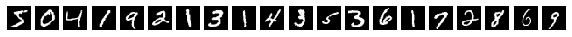

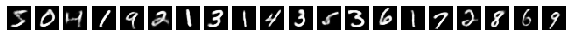

In [42]:
cvae_recons = cvae.predict([x_train,y_train],batch_size=batch_size)
Plot_Img(20,28,x_train,10,10)
Plot_Img(20,28,cvae_recons,10,10)
plt.show()

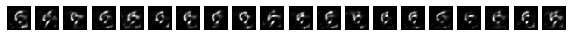

In [54]:
z_sample = np.random.normal(size=(batch_size,h_dim,))
z_sample = tf.convert_to_tensor(z_sample, dtype=tf.float32)
cond_sample = np.zeros(shape=(100,10))
cond_sample[:,9] = 1
cond_sample = tf.convert_to_tensor(cond_sample, dtype=tf.float32)
Plot_Img(20,28,cvae_decoder.predict([z_sample,cond_sample],steps=1),10,10)